# 锚框
:label:`sec_anchor`

目标检测算法通常会在输入图像中采样大量的区域，然后判断这些区域中是否包含我们感兴趣的目标，并调整区域边界从而更准确地预测目标的*真实边界框*（ground-truth bounding box）。
不同的模型使用的区域采样方法可能不同。
这里我们介绍其中的一种方法：以每个像素为中心，生成多个缩放比和宽高比（aspect ratio）不同的边界框。
这些边界框被称为*锚框*（anchor box）我们将在 :numref:`sec_ssd`中设计一个基于锚框的目标检测模型。

首先，让我们修改输出精度，以获得更简洁的输出。


In [4]:
# 将当前的matplotlib生成的图片嵌入到当前的命令行,如果不加，显示的图片会有一个独立的窗口
%matplotlib inline
# 导入深度学习包
import torch
# 从d2l中提供的4个接口中的torch中进行设置
from d2l import torch as d2l
# 精简输出精度
torch.set_printoptions(2)  

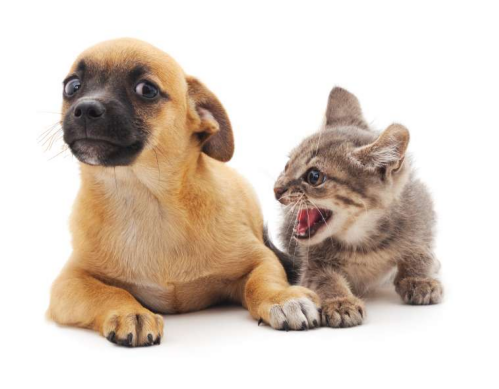

In [ ]:
%matplotlib inline 

import cv2
import matplotlib.pyplot as plt

# 读取图片
img = cv2.imread('../img/catdog.jpg')

# 检查图片是否成功读取
if img is not None:
    # 显示图片
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # 使用matplotlib
    plt.imshow(img_rgb)
    # 关闭坐标
    plt.axis('off')
    plt.show()
else:
    print("图片读取失败，请检查路径是否正确。")


## 生成多个锚框

假设输入图像的高度为$h$，宽度为$w$。
我们以图像的每个像素为中心生成不同形状的锚框：*缩放比*为$s\in (0, 1]$，*宽高比*为$r > 0$。
那么[**锚框的宽度和高度分别是$hs\sqrt{r}$和$hs/\sqrt{r}$。**]
请注意，当中心位置给定时，已知宽和高的锚框是确定的。

要生成多个不同形状的锚框，让我们设置许多缩放比（scale）取值$s_1,\ldots, s_n$和许多宽高比（aspect ratio）取值$r_1,\ldots, r_m$。
当使用这些比例和长宽比的所有组合以每个像素为中心时，输入图像将总共有$whnm$个锚框。
尽管这些锚框可能会覆盖所有真实边界框，但计算复杂性很容易过高。
在实践中，(**我们只考虑**)包含$s_1$或$r_1$的(**组合：**)

(**
$$(s_1, r_1), (s_1, r_2), \ldots, (s_1, r_m), (s_2, r_1), (s_3, r_1), \ldots, (s_n, r_1).$$
**)

也就是说，以同一像素为中心的锚框的数量是$n+m-1$。
对于整个输入图像，将共生成$wh(n+m-1)$个锚框。

上述生成锚框的方法在下面的`multibox_prior`函数中实现。
我们指定输入图像、尺寸列表和宽高比列表，然后此函数将返回所有的锚框。


In [ ]:
#@save
def multibox_prior(data, sizes, ratios):
    """生成以每个像素为中心具有不同形状的锚框"""
    # 获取当前输入的高、宽
    in_height, in_width = data.shape[-2:]
    # 将当前数据的具体需要变换的放缩比和宽高比具体的size进行录入，并且控制当前数据的流向方式
    device, num_sizes, num_ratios = data.device, len(sizes), len(ratios)
    # 这个是上面已经计算得到的一种简易计算方式
    boxes_per_pixel = (num_sizes + num_ratios - 1)

    size_tensor = torch.tensor(sizes, device=device)
    ratio_tensor = torch.tensor(ratios, device=device)

    # 为了将锚点移动到像素的中心，需要设置偏移量。
    # 因为一个像素的高为1且宽为1，我们选择偏移我们的中心0.5
    offset_h, offset_w = 0.5, 0.5
    # 想成一种归一化的步长
    steps_h = 1.0 / in_height  # 在y轴上缩放步长
    steps_w = 1.0 / in_width  # 在x轴上缩放步长

    # 生成锚框的所有中心点
    center_h = (torch.arange(in_height, device=device) + offset_h) * steps_h
    center_w = (torch.arange(in_width, device=device) + offset_w) * steps_w
    
    shift_y, shift_x = torch.meshgrid(center_h, center_w, indexing='ij')
    shift_y, shift_x = shift_y.reshape(-1), shift_x.reshape(-1)

    # 生成“boxes_per_pixel”个高和宽，
    # 之后用于创建锚框的四角坐标(xmin,xmax,ymin,ymax)
    w = torch.cat((size_tensor * torch.sqrt(ratio_tensor[0]),
                   sizes[0] * torch.sqrt(ratio_tensor[1:])))\
                   * in_height / in_width  # 处理矩形输入
    h = torch.cat((size_tensor / torch.sqrt(ratio_tensor[0]),
                   sizes[0] / torch.sqrt(ratio_tensor[1:])))
    # 除以2来获得半高和半宽
    anchor_manipulations = torch.stack((-w, -h, w, h)).T.repeat(
                                        in_height * in_width, 1) / 2

    # 每个中心点都将有“boxes_per_pixel”个锚框，
    # 所以生成含所有锚框中心的网格，重复了“boxes_per_pixel”次
    out_grid = torch.stack([shift_x, shift_y, shift_x, shift_y],
                dim=1).repeat_interleave(boxes_per_pixel, dim=0)
    output = out_grid + anchor_manipulations
    return output.unsqueeze(0)

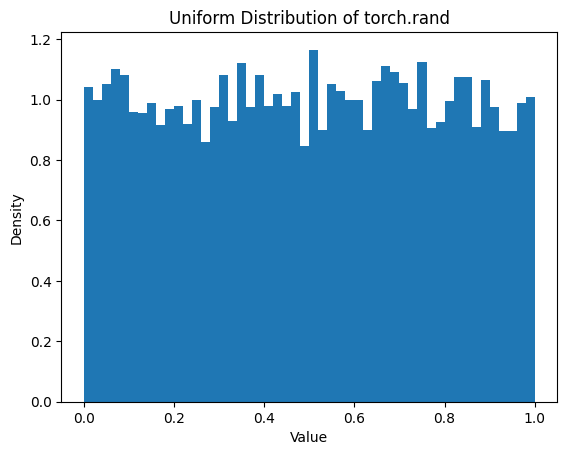

Mean: 0.4992785155773163 (Expected: 0.5)
Variance: 0.0831264778971672 (Expected: 0.08333333333333333)


In [14]:
import torch
import matplotlib.pyplot as plt

# 生成 10000 个随机数
random_numbers = torch.rand(10000)

# 绘制直方图
plt.hist(random_numbers.numpy(), bins=50, density=True)
plt.title("Uniform Distribution of torch.rand")
plt.xlabel("Value")
plt.ylabel("Density")
plt.show()

mean = random_numbers.mean()
variance = random_numbers.var()

print(f"Mean: {mean.item()} (Expected: 0.5)")
print(f"Variance: {variance.item()} (Expected: {1/12})")



可以看到[**返回的锚框变量`Y`的形状**]是（批量大小，锚框的数量，4）。


In [17]:
# 通过d2l中调用matplotlib.pyplot然后进行图片读取到的array数组中
img = d2l.plt.imread('../img/catdog.jpg')
# 高和宽对应着0、1
h, w = img.shape[:2]

print(h, w)
# 返回一个填满了区间 [0,1)上均匀分布的随机数的张量（https://pytorch.org/docs/stable/generated/torch.rand.html）
X = torch.rand(size=(1, 3, h, w))
# 在当前的这个随机生成的类似于上面图片上面进行创建,输入放缩比为三个、宽高比为三个
Y = multibox_prior(X, sizes=[0.75, 0.5, 0.25], ratios=[1, 2, 0.5])
Y.shape

561 728


torch.Size([1, 2042040, 4])

In [4]:
img.shape

(561, 728, 3)

将锚框变量`Y`的形状更改为(图像高度,图像宽度,以同一像素为中心的锚框的数量,4)后，我们可以获得以指定像素的位置为中心的所有锚框。
在接下来的内容中，我们[**访问以（250,250）为中心的第一个锚框**]。
它有四个元素：锚框左上角的$(x, y)$轴坐标和右下角的$(x, y)$轴坐标。
输出中两个轴的坐标各分别除以了图像的宽度和高度。


In [4]:
boxes = Y.reshape(h, w, 5, 4)
boxes[250, 250, 0, :]

tensor([0.06, 0.07, 0.63, 0.82])

为了[**显示以图像中以某个像素为中心的所有锚框**]，定义下面的`show_bboxes`函数来在图像上绘制多个边界框。


In [5]:
#@save
def show_bboxes(axes, bboxes, labels=None, colors=None):
    """显示所有边界框"""
    def _make_list(obj, default_values=None):
        if obj is None:
            obj = default_values
        elif not isinstance(obj, (list, tuple)):
            obj = [obj]
        return obj

    labels = _make_list(labels)
    colors = _make_list(colors, ['b', 'g', 'r', 'm', 'c'])
    for i, bbox in enumerate(bboxes):
        color = colors[i % len(colors)]
        rect = d2l.bbox_to_rect(bbox.detach().numpy(), color)
        axes.add_patch(rect)
        if labels and len(labels) > i:
            text_color = 'k' if color == 'w' else 'w'
            axes.text(rect.xy[0], rect.xy[1], labels[i],
                      va='center', ha='center', fontsize=9, color=text_color,
                      bbox=dict(facecolor=color, lw=0))

正如从上面代码中所看到的，变量`boxes`中$x$轴和$y$轴的坐标值已分别除以图像的宽度和高度。
绘制锚框时，我们需要恢复它们原始的坐标值。
因此，在下面定义了变量`bbox_scale`。
现在可以绘制出图像中所有以(250,250)为中心的锚框了。
如下所示，缩放比为0.75且宽高比为1的蓝色锚框很好地围绕着图像中的狗。


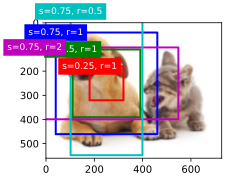

In [6]:
d2l.set_figsize()
bbox_scale = torch.tensor((w, h, w, h))
fig = d2l.plt.imshow(img)
show_bboxes(fig.axes, boxes[250, 250, :, :] * bbox_scale,
            ['s=0.75, r=1', 's=0.5, r=1', 's=0.25, r=1', 's=0.75, r=2',
             's=0.75, r=0.5'])

## [**交并比（IoU）**]

我们刚刚提到某个锚框“较好地”覆盖了图像中的狗。
如果已知目标的真实边界框，那么这里的“好”该如何如何量化呢？
直观地说，可以衡量锚框和真实边界框之间的相似性。
*杰卡德系数*（Jaccard）可以衡量两组之间的相似性。
给定集合$\mathcal{A}$和$\mathcal{B}$，他们的杰卡德系数是他们交集的大小除以他们并集的大小：

$$J(\mathcal{A},\mathcal{B}) = \frac{\left|\mathcal{A} \cap \mathcal{B}\right|}{\left| \mathcal{A} \cup \mathcal{B}\right|}.$$

事实上，我们可以将任何边界框的像素区域视为一组像素。通
过这种方式，我们可以通过其像素集的杰卡德系数来测量两个边界框的相似性。
对于两个边界框，它们的杰卡德系数通常称为*交并比*（intersection over union，IoU），即两个边界框相交面积与相并面积之比，如 :numref:`fig_iou`所示。
交并比的取值范围在0和1之间：0表示两个边界框无重合像素，1表示两个边界框完全重合。

![交并比是两个边界框相交面积与相并面积之比。](../img/iou.svg)
:label:`fig_iou`

接下来部分将使用交并比来衡量锚框和真实边界框之间、以及不同锚框之间的相似度。
给定两个锚框或边界框的列表，以下`box_iou`函数将在这两个列表中计算它们成对的交并比。


In [7]:
#@save
def box_iou(boxes1, boxes2):
    """计算两个锚框或边界框列表中成对的交并比"""
    box_area = lambda boxes: ((boxes[:, 2] - boxes[:, 0]) *
                              (boxes[:, 3] - boxes[:, 1]))
    # boxes1,boxes2,areas1,areas2的形状:
    # boxes1：(boxes1的数量,4),
    # boxes2：(boxes2的数量,4),
    # areas1：(boxes1的数量,),
    # areas2：(boxes2的数量,)
    areas1 = box_area(boxes1)
    areas2 = box_area(boxes2)
    # inter_upperlefts,inter_lowerrights,inters的形状:
    # (boxes1的数量,boxes2的数量,2)
    inter_upperlefts = torch.max(boxes1[:, None, :2], boxes2[:, :2])
    inter_lowerrights = torch.min(boxes1[:, None, 2:], boxes2[:, 2:])
    inters = (inter_lowerrights - inter_upperlefts).clamp(min=0)
    # inter_areasandunion_areas的形状:(boxes1的数量,boxes2的数量)
    inter_areas = inters[:, :, 0] * inters[:, :, 1]
    union_areas = areas1[:, None] + areas2 - inter_areas
    return inter_areas / union_areas

## 在训练数据中标注锚框
:label:`subsec_labeling-anchor-boxes`

在训练集中，我们将每个锚框视为一个训练样本。
为了训练目标检测模型，我们需要每个锚框的*类别*（class）和*偏移量*（offset）标签，其中前者是与锚框相关的对象的类别，后者是真实边界框相对于锚框的偏移量。
在预测时，我们为每个图像生成多个锚框，预测所有锚框的类别和偏移量，根据预测的偏移量调整它们的位置以获得预测的边界框，最后只输出符合特定条件的预测边界框。

目标检测训练集带有*真实边界框*的位置及其包围物体类别的标签。
要标记任何生成的锚框，我们可以参考分配到的最接近此锚框的真实边界框的位置和类别标签。
下文将介绍一个算法，它能够把最接近的真实边界框分配给锚框。

### [**将真实边界框分配给锚框**]

给定图像，假设锚框是$A_1, A_2, \ldots, A_{n_a}$，真实边界框是$B_1, B_2, \ldots, B_{n_b}$，其中$n_a \geq n_b$。
让我们定义一个矩阵$\mathbf{X} \in \mathbb{R}^{n_a \times n_b}$，其中第$i$行、第$j$列的元素$x_{ij}$是锚框$A_i$和真实边界框$B_j$的IoU。
该算法包含以下步骤。

1. 在矩阵$\mathbf{X}$中找到最大的元素，并将它的行索引和列索引分别表示为$i_1$和$j_1$。然后将真实边界框$B_{j_1}$分配给锚框$A_{i_1}$。这很直观，因为$A_{i_1}$和$B_{j_1}$是所有锚框和真实边界框配对中最相近的。在第一个分配完成后，丢弃矩阵中${i_1}^\mathrm{th}$行和${j_1}^\mathrm{th}$列中的所有元素。
1. 在矩阵$\mathbf{X}$中找到剩余元素中最大的元素，并将它的行索引和列索引分别表示为$i_2$和$j_2$。我们将真实边界框$B_{j_2}$分配给锚框$A_{i_2}$，并丢弃矩阵中${i_2}^\mathrm{th}$行和${j_2}^\mathrm{th}$列中的所有元素。
1. 此时，矩阵$\mathbf{X}$中两行和两列中的元素已被丢弃。我们继续，直到丢弃掉矩阵$\mathbf{X}$中$n_b$列中的所有元素。此时已经为这$n_b$个锚框各自分配了一个真实边界框。
1. 只遍历剩下的$n_a - n_b$个锚框。例如，给定任何锚框$A_i$，在矩阵$\mathbf{X}$的第$i^\mathrm{th}$行中找到与$A_i$的IoU最大的真实边界框$B_j$，只有当此IoU大于预定义的阈值时，才将$B_j$分配给$A_i$。

下面用一个具体的例子来说明上述算法。
如 :numref:`fig_anchor_label`（左）所示，假设矩阵$\mathbf{X}$中的最大值为$x_{23}$，我们将真实边界框$B_3$分配给锚框$A_2$。
然后，我们丢弃矩阵第2行和第3列中的所有元素，在剩余元素（阴影区域）中找到最大的$x_{71}$，然后将真实边界框$B_1$分配给锚框$A_7$。
接下来，如 :numref:`fig_anchor_label`（中）所示，丢弃矩阵第7行和第1列中的所有元素，在剩余元素（阴影区域）中找到最大的$x_{54}$，然后将真实边界框$B_4$分配给锚框$A_5$。
最后，如 :numref:`fig_anchor_label`（右）所示，丢弃矩阵第5行和第4列中的所有元素，在剩余元素（阴影区域）中找到最大的$x_{92}$，然后将真实边界框$B_2$分配给锚框$A_9$。
之后，我们只需要遍历剩余的锚框$A_1, A_3, A_4, A_6, A_8$，然后根据阈值确定是否为它们分配真实边界框。

![将真实边界框分配给锚框。](../img/anchor-label.svg)
:label:`fig_anchor_label`

此算法在下面的`assign_anchor_to_bbox`函数中实现。


In [8]:
#@save
def assign_anchor_to_bbox(ground_truth, anchors, device, iou_threshold=0.5):
    """将最接近的真实边界框分配给锚框"""
    num_anchors, num_gt_boxes = anchors.shape[0], ground_truth.shape[0]
    # 位于第i行和第j列的元素x_ij是锚框i和真实边界框j的IoU
    jaccard = box_iou(anchors, ground_truth)
    # 对于每个锚框，分配的真实边界框的张量
    anchors_bbox_map = torch.full((num_anchors,), -1, dtype=torch.long,
                                  device=device)
    # 根据阈值，决定是否分配真实边界框
    max_ious, indices = torch.max(jaccard, dim=1)
    anc_i = torch.nonzero(max_ious >= iou_threshold).reshape(-1)
    box_j = indices[max_ious >= iou_threshold]
    anchors_bbox_map[anc_i] = box_j
    col_discard = torch.full((num_anchors,), -1)
    row_discard = torch.full((num_gt_boxes,), -1)
    for _ in range(num_gt_boxes):
        max_idx = torch.argmax(jaccard)
        box_idx = (max_idx % num_gt_boxes).long()
        anc_idx = (max_idx / num_gt_boxes).long()
        anchors_bbox_map[anc_idx] = box_idx
        jaccard[:, box_idx] = col_discard
        jaccard[anc_idx, :] = row_discard
    return anchors_bbox_map

### 标记类别和偏移量

现在我们可以为每个锚框标记类别和偏移量了。
假设一个锚框$A$被分配了一个真实边界框$B$。
一方面，锚框$A$的类别将被标记为与$B$相同。
另一方面，锚框$A$的偏移量将根据$B$和$A$中心坐标的相对位置以及这两个框的相对大小进行标记。
鉴于数据集内不同的框的位置和大小不同，我们可以对那些相对位置和大小应用变换，使其获得分布更均匀且易于拟合的偏移量。
这里介绍一种常见的变换。
[**给定框$A$和$B$，中心坐标分别为$(x_a, y_a)$和$(x_b, y_b)$，宽度分别为$w_a$和$w_b$，高度分别为$h_a$和$h_b$，可以将$A$的偏移量标记为：

$$\left( \frac{ \frac{x_b - x_a}{w_a} - \mu_x }{\sigma_x},
\frac{ \frac{y_b - y_a}{h_a} - \mu_y }{\sigma_y},
\frac{ \log \frac{w_b}{w_a} - \mu_w }{\sigma_w},
\frac{ \log \frac{h_b}{h_a} - \mu_h }{\sigma_h}\right),$$
**]
其中常量的默认值为 $\mu_x = \mu_y = \mu_w = \mu_h = 0, \sigma_x=\sigma_y=0.1$ ， $\sigma_w=\sigma_h=0.2$。
这种转换在下面的 `offset_boxes` 函数中实现。


In [9]:
#@save
def offset_boxes(anchors, assigned_bb, eps=1e-6):
    """对锚框偏移量的转换"""
    c_anc = d2l.box_corner_to_center(anchors)
    c_assigned_bb = d2l.box_corner_to_center(assigned_bb)
    offset_xy = 10 * (c_assigned_bb[:, :2] - c_anc[:, :2]) / c_anc[:, 2:]
    offset_wh = 5 * torch.log(eps + c_assigned_bb[:, 2:] / c_anc[:, 2:])
    offset = torch.cat([offset_xy, offset_wh], axis=1)
    return offset

如果一个锚框没有被分配真实边界框，我们只需将锚框的类别标记为*背景*（background）。
背景类别的锚框通常被称为*负类*锚框，其余的被称为*正类*锚框。
我们使用真实边界框（`labels`参数）实现以下`multibox_target`函数，来[**标记锚框的类别和偏移量**]（`anchors`参数）。
此函数将背景类别的索引设置为零，然后将新类别的整数索引递增一。


In [10]:
#@save
def multibox_target(anchors, labels):
    """使用真实边界框标记锚框"""
    batch_size, anchors = labels.shape[0], anchors.squeeze(0)
    batch_offset, batch_mask, batch_class_labels = [], [], []
    device, num_anchors = anchors.device, anchors.shape[0]
    for i in range(batch_size):
        label = labels[i, :, :]
        anchors_bbox_map = assign_anchor_to_bbox(
            label[:, 1:], anchors, device)
        bbox_mask = ((anchors_bbox_map >= 0).float().unsqueeze(-1)).repeat(
            1, 4)
        # 将类标签和分配的边界框坐标初始化为零
        class_labels = torch.zeros(num_anchors, dtype=torch.long,
                                   device=device)
        assigned_bb = torch.zeros((num_anchors, 4), dtype=torch.float32,
                                  device=device)
        # 使用真实边界框来标记锚框的类别。
        # 如果一个锚框没有被分配，标记其为背景（值为零）
        indices_true = torch.nonzero(anchors_bbox_map >= 0)
        bb_idx = anchors_bbox_map[indices_true]
        class_labels[indices_true] = label[bb_idx, 0].long() + 1
        assigned_bb[indices_true] = label[bb_idx, 1:]
        # 偏移量转换
        offset = offset_boxes(anchors, assigned_bb) * bbox_mask
        batch_offset.append(offset.reshape(-1))
        batch_mask.append(bbox_mask.reshape(-1))
        batch_class_labels.append(class_labels)
    bbox_offset = torch.stack(batch_offset)
    bbox_mask = torch.stack(batch_mask)
    class_labels = torch.stack(batch_class_labels)
    return (bbox_offset, bbox_mask, class_labels)

### 一个例子

下面通过一个具体的例子来说明锚框标签。
我们已经为加载图像中的狗和猫定义了真实边界框，其中第一个元素是类别（0代表狗，1代表猫），其余四个元素是左上角和右下角的$(x, y)$轴坐标（范围介于0和1之间）。
我们还构建了五个锚框，用左上角和右下角的坐标进行标记：$A_0, \ldots, A_4$（索引从0开始）。
然后我们[**在图像中绘制这些真实边界框和锚框**]。


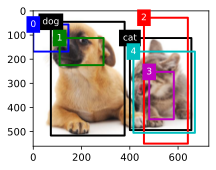

In [11]:
ground_truth = torch.tensor([[0, 0.1, 0.08, 0.52, 0.92],
                         [1, 0.55, 0.2, 0.9, 0.88]])
anchors = torch.tensor([[0, 0.1, 0.2, 0.3], [0.15, 0.2, 0.4, 0.4],
                    [0.63, 0.05, 0.88, 0.98], [0.66, 0.45, 0.8, 0.8],
                    [0.57, 0.3, 0.92, 0.9]])

fig = d2l.plt.imshow(img)
show_bboxes(fig.axes, ground_truth[:, 1:] * bbox_scale, ['dog', 'cat'], 'k')
show_bboxes(fig.axes, anchors * bbox_scale, ['0', '1', '2', '3', '4']);

使用上面定义的`multibox_target`函数，我们可以[**根据狗和猫的真实边界框，标注这些锚框的分类和偏移量**]。
在这个例子中，背景、狗和猫的类索引分别为0、1和2。
下面我们为锚框和真实边界框样本添加一个维度。


In [12]:
labels = multibox_target(anchors.unsqueeze(dim=0),
                         ground_truth.unsqueeze(dim=0))

返回的结果中有三个元素，都是张量格式。第三个元素包含标记的输入锚框的类别。

让我们根据图像中的锚框和真实边界框的位置来分析下面返回的类别标签。
首先，在所有的锚框和真实边界框配对中，锚框$A_4$与猫的真实边界框的IoU是最大的。
因此，$A_4$的类别被标记为猫。
去除包含$A_4$或猫的真实边界框的配对，在剩下的配对中，锚框$A_1$和狗的真实边界框有最大的IoU。
因此，$A_1$的类别被标记为狗。
接下来，我们需要遍历剩下的三个未标记的锚框：$A_0$、$A_2$和$A_3$。
对于$A_0$，与其拥有最大IoU的真实边界框的类别是狗，但IoU低于预定义的阈值（0.5），因此该类别被标记为背景；
对于$A_2$，与其拥有最大IoU的真实边界框的类别是猫，IoU超过阈值，所以类别被标记为猫；
对于$A_3$，与其拥有最大IoU的真实边界框的类别是猫，但值低于阈值，因此该类别被标记为背景。


In [13]:
labels[2]

tensor([[0, 1, 2, 0, 2]])

返回的第二个元素是掩码（mask）变量，形状为（批量大小，锚框数的四倍）。
掩码变量中的元素与每个锚框的4个偏移量一一对应。
由于我们不关心对背景的检测，负类的偏移量不应影响目标函数。
通过元素乘法，掩码变量中的零将在计算目标函数之前过滤掉负类偏移量。


In [14]:
labels[1]

tensor([[0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1.,
         1., 1.]])

返回的第一个元素包含了为每个锚框标记的四个偏移值。
请注意，负类锚框的偏移量被标记为零。


In [15]:
labels[0]

tensor([[-0.00e+00, -0.00e+00, -0.00e+00, -0.00e+00,  1.40e+00,  1.00e+01,
          2.59e+00,  7.18e+00, -1.20e+00,  2.69e-01,  1.68e+00, -1.57e+00,
         -0.00e+00, -0.00e+00, -0.00e+00, -0.00e+00, -5.71e-01, -1.00e+00,
          4.17e-06,  6.26e-01]])

## 使用非极大值抑制预测边界框
:label:`subsec_predicting-bounding-boxes-nms`

在预测时，我们先为图像生成多个锚框，再为这些锚框一一预测类别和偏移量。
一个*预测好的边界框*则根据其中某个带有预测偏移量的锚框而生成。
下面我们实现了`offset_inverse`函数，该函数将锚框和偏移量预测作为输入，并[**应用逆偏移变换来返回预测的边界框坐标**]。


In [16]:
#@save
def offset_inverse(anchors, offset_preds):
    """根据带有预测偏移量的锚框来预测边界框"""
    anc = d2l.box_corner_to_center(anchors)
    pred_bbox_xy = (offset_preds[:, :2] * anc[:, 2:] / 10) + anc[:, :2]
    pred_bbox_wh = torch.exp(offset_preds[:, 2:] / 5) * anc[:, 2:]
    pred_bbox = torch.cat((pred_bbox_xy, pred_bbox_wh), axis=1)
    predicted_bbox = d2l.box_center_to_corner(pred_bbox)
    return predicted_bbox

当有许多锚框时，可能会输出许多相似的具有明显重叠的预测边界框，都围绕着同一目标。
为了简化输出，我们可以使用*非极大值抑制*（non-maximum suppression，NMS）合并属于同一目标的类似的预测边界框。

以下是非极大值抑制的工作原理。
对于一个预测边界框$B$，目标检测模型会计算每个类别的预测概率。
假设最大的预测概率为$p$，则该概率所对应的类别$B$即为预测的类别。
具体来说，我们将$p$称为预测边界框$B$的*置信度*（confidence）。
在同一张图像中，所有预测的非背景边界框都按置信度降序排序，以生成列表$L$。然后我们通过以下步骤操作排序列表$L$。

1. 从$L$中选取置信度最高的预测边界框$B_1$作为基准，然后将所有与$B_1$的IoU超过预定阈值$\epsilon$的非基准预测边界框从$L$中移除。这时，$L$保留了置信度最高的预测边界框，去除了与其太过相似的其他预测边界框。简而言之，那些具有*非极大值*置信度的边界框被*抑制*了。
1. 从$L$中选取置信度第二高的预测边界框$B_2$作为又一个基准，然后将所有与$B_2$的IoU大于$\epsilon$的非基准预测边界框从$L$中移除。
1. 重复上述过程，直到$L$中的所有预测边界框都曾被用作基准。此时，$L$中任意一对预测边界框的IoU都小于阈值$\epsilon$；因此，没有一对边界框过于相似。
1. 输出列表$L$中的所有预测边界框。

[**以下`nms`函数按降序对置信度进行排序并返回其索引**]。


In [17]:
#@save
def nms(boxes, scores, iou_threshold):
    """对预测边界框的置信度进行排序"""
    B = torch.argsort(scores, dim=-1, descending=True)
    keep = []  # 保留预测边界框的指标
    while B.numel() > 0:
        i = B[0]
        keep.append(i)
        if B.numel() == 1: break
        iou = box_iou(boxes[i, :].reshape(-1, 4),
                      boxes[B[1:], :].reshape(-1, 4)).reshape(-1)
        inds = torch.nonzero(iou <= iou_threshold).reshape(-1)
        B = B[inds + 1]
    return torch.tensor(keep, device=boxes.device)

我们定义以下`multibox_detection`函数来[**将非极大值抑制应用于预测边界框**]。
这里的实现有点复杂，请不要担心。我们将在实现之后，马上用一个具体的例子来展示它是如何工作的。


In [18]:
#@save
def multibox_detection(cls_probs, offset_preds, anchors, nms_threshold=0.5,
                       pos_threshold=0.009999999):
    """使用非极大值抑制来预测边界框"""
    device, batch_size = cls_probs.device, cls_probs.shape[0]
    anchors = anchors.squeeze(0)
    num_classes, num_anchors = cls_probs.shape[1], cls_probs.shape[2]
    out = []
    for i in range(batch_size):
        cls_prob, offset_pred = cls_probs[i], offset_preds[i].reshape(-1, 4)
        conf, class_id = torch.max(cls_prob[1:], 0)
        predicted_bb = offset_inverse(anchors, offset_pred)
        keep = nms(predicted_bb, conf, nms_threshold)

        # 找到所有的non_keep索引，并将类设置为背景
        all_idx = torch.arange(num_anchors, dtype=torch.long, device=device)
        combined = torch.cat((keep, all_idx))
        uniques, counts = combined.unique(return_counts=True)
        non_keep = uniques[counts == 1]
        all_id_sorted = torch.cat((keep, non_keep))
        class_id[non_keep] = -1
        class_id = class_id[all_id_sorted]
        conf, predicted_bb = conf[all_id_sorted], predicted_bb[all_id_sorted]
        # pos_threshold是一个用于非背景预测的阈值
        below_min_idx = (conf < pos_threshold)
        class_id[below_min_idx] = -1
        conf[below_min_idx] = 1 - conf[below_min_idx]
        pred_info = torch.cat((class_id.unsqueeze(1),
                               conf.unsqueeze(1),
                               predicted_bb), dim=1)
        out.append(pred_info)
    return torch.stack(out)

现在让我们[**将上述算法应用到一个带有四个锚框的具体示例中**]。
为简单起见，我们假设预测的偏移量都是零，这意味着预测的边界框即是锚框。
对于背景、狗和猫其中的每个类，我们还定义了它的预测概率。


In [19]:
anchors = torch.tensor([[0.1, 0.08, 0.52, 0.92], [0.08, 0.2, 0.56, 0.95],
                      [0.15, 0.3, 0.62, 0.91], [0.55, 0.2, 0.9, 0.88]])
offset_preds = torch.tensor([0] * anchors.numel())
cls_probs = torch.tensor([[0] * 4,  # 背景的预测概率
                      [0.9, 0.8, 0.7, 0.1],  # 狗的预测概率
                      [0.1, 0.2, 0.3, 0.9]])  # 猫的预测概率

我们可以[**在图像上绘制这些预测边界框和置信度**]。


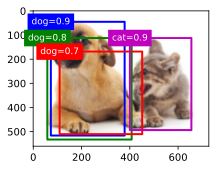

In [20]:
fig = d2l.plt.imshow(img)
show_bboxes(fig.axes, anchors * bbox_scale,
            ['dog=0.9', 'dog=0.8', 'dog=0.7', 'cat=0.9'])

现在我们可以调用`multibox_detection`函数来执行非极大值抑制，其中阈值设置为0.5。
请注意，我们在示例的张量输入中添加了维度。

我们可以看到[**返回结果的形状是（批量大小，锚框的数量，6）**]。
最内层维度中的六个元素提供了同一预测边界框的输出信息。
第一个元素是预测的类索引，从0开始（0代表狗，1代表猫），值-1表示背景或在非极大值抑制中被移除了。
第二个元素是预测的边界框的置信度。
其余四个元素分别是预测边界框左上角和右下角的$(x, y)$轴坐标（范围介于0和1之间）。


In [21]:
output = multibox_detection(cls_probs.unsqueeze(dim=0),
                            offset_preds.unsqueeze(dim=0),
                            anchors.unsqueeze(dim=0),
                            nms_threshold=0.5)
output

tensor([[[ 0.00,  0.90,  0.10,  0.08,  0.52,  0.92],
         [ 1.00,  0.90,  0.55,  0.20,  0.90,  0.88],
         [-1.00,  0.80,  0.08,  0.20,  0.56,  0.95],
         [-1.00,  0.70,  0.15,  0.30,  0.62,  0.91]]])

删除-1类别（背景）的预测边界框后，我们可以[**输出由非极大值抑制保存的最终预测边界框**]。


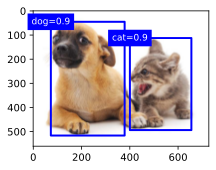

In [22]:
fig = d2l.plt.imshow(img)
for i in output[0].detach().numpy():
    if i[0] == -1:
        continue
    label = ('dog=', 'cat=')[int(i[0])] + str(i[1])
    show_bboxes(fig.axes, [torch.tensor(i[2:]) * bbox_scale], label)

实践中，在执行非极大值抑制前，我们甚至可以将置信度较低的预测边界框移除，从而减少此算法中的计算量。
我们也可以对非极大值抑制的输出结果进行后处理。例如，只保留置信度更高的结果作为最终输出。

## 小结

* 我们以图像的每个像素为中心生成不同形状的锚框。
* 交并比（IoU）也被称为杰卡德系数，用于衡量两个边界框的相似性。它是相交面积与相并面积的比率。
* 在训练集中，我们需要给每个锚框两种类型的标签。一个是与锚框中目标检测的类别，另一个是锚框真实相对于边界框的偏移量。
* 预测期间可以使用非极大值抑制（NMS）来移除类似的预测边界框，从而简化输出。

## 练习

1. 在`multibox_prior`函数中更改`sizes`和`ratios`的值。生成的锚框有什么变化？
1. 构建并可视化两个IoU为0.5的边界框。它们是怎样重叠的？
1. 在 :numref:`subsec_labeling-anchor-boxes`和 :numref:`subsec_predicting-bounding-boxes-nms`中修改变量`anchors`，结果如何变化？
1. 非极大值抑制是一种贪心算法，它通过*移除*来抑制预测的边界框。是否存在一种可能，被移除的一些框实际上是有用的？如何修改这个算法来柔和地抑制？可以参考Soft-NMS :cite:`Bodla.Singh.Chellappa.ea.2017`。
1. 如果非手动，非最大限度的抑制可以被学习吗？


[Discussions](https://discuss.d2l.ai/t/2946)
